## Instalar dependencias necesaria

In [1]:
!pip install pycryptodome

   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.8 MB 131.3 kB/s eta 0:00:14
   ---------------------------------------- 0.0/1.8 MB 131.3 kB/s eta 0:00:14
    --------------------------------------- 0.0/1.8 MB 145.2 kB/s eta 0:00:13
   - -------------------------------------- 0.1/1.8 MB 233.8 kB/s eta 0:00:08
   -- ------------------------------------- 0.1/1.8 MB 308.0 kB/s eta 0:00:06
   --- ------------------------------------ 0.2/1.8 MB 523.5 kB/s eta 0:00:04
   ------ --------------------------------- 0.3/1.8 MB 737.3 kB/s eta 0:00:03
   ---------- ----------------------------- 0.5/1.8 MB 1.0 MB/s eta 0:00:02
   ------------- -------------------------- 0.6/1.8 MB 1.3 MB/s eta 0:00:01
   ----------------- ---------------------- 0.8/1.8 MB 1.5 MB/s eta 0:00:01
   ----------------


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!pip install matplotlib

     ---------------------------------------- 0.0/110.1 kB ? eta -:--:--
     --- ------------------------------------ 10.2/110.1 kB ? eta -:--:--
     --- ------------------------------------ 10.2/110.1 kB ? eta -:--:--
     ------------- ----------------------- 41.0/110.1 kB 281.8 kB/s eta 0:00:01
     ------------------------------ ------ 92.2/110.1 kB 525.1 kB/s eta 0:00:01
     ------------------------------------ 110.1/110.1 kB 580.3 kB/s eta 0:00:00
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
    --------------------------------------- 0.1/8.1 MB 4.3 MB/s eta 0:00:02
    --------------------------------------- 0.2/8.1 MB 2.4 MB/s eta 0:00:04
   - -------------------------------------- 0.4/8.1 MB 3.0 MB/s eta 0:00:03
   -- ------------------------------------- 0.5/8.1 MB 3.1 MB/s eta 0:00:03
   --- ------------------------------------ 0.7/8.1 MB 3.4 MB/s eta 0:00:03
   ----- ---------------------------------- 1.1/8.1 MB 4.0 MB/s eta 0:00:02
   ------- ---


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Introducción

# 🔐 Algoritmo Paillier: Cifrado Homomórfico

Este notebook implementa el algoritmo de Paillier en Python para:
- Cifrar y descifrar mensajes enteros.
- Probar si es **probabilístico o determinista**.
- Aplicar propiedades **homomórficas (suma y multiplicación)**.
- Medir el rendimiento de cifrado y descifrado con diferentes tamaños de claves.

## Implementación del algoritmo Paillier

In [4]:
from Crypto.Util import number
import random
import time
import matplotlib.pyplot as plt

class Paillier:
    def __init__(self, bit_length=128):
        self.bit_length = bit_length
        self.p = number.getPrime(bit_length // 2)
        self.q = number.getPrime(bit_length // 2)
        while self.q == self.p:
            self.q = number.getPrime(bit_length // 2)
        self.n = self.p * self.q
        self.nsquare = self.n * self.n
        self.lambda_param = (self.p - 1) * (self.q - 1) // number.GCD(self.p - 1, self.q - 1)
        self.g = self._find_valid_g()
        self.mu = number.inverse(self.L_function(pow(self.g, self.lambda_param, self.nsquare)), self.n)

    def L_function(self, x):
        return (x - 1) // self.n

    def _find_valid_g(self):
        while True:
            g = random.randrange(1, self.nsquare)
            l_val = self.L_function(pow(g, self.lambda_param, self.nsquare))
            if number.GCD(l_val, self.n) == 1:
                return g

    def encrypt(self, m, r=None):
        if not (0 <= m < self.n):
            raise ValueError("Plaintext must be in Z_n")
        if r is None:
            r = random.randrange(1, self.n)
            while number.GCD(r, self.n) != 1:
                r = random.randrange(1, self.n)
        c = (pow(self.g, m, self.nsquare) * pow(r, self.n, self.nsquare)) % self.nsquare
        return c

    def decrypt(self, c):
        if not (0 <= c < self.nsquare):
            raise ValueError("Ciphertext must be in Z_{n^2}")
        u = self.L_function(pow(c, self.lambda_param, self.nsquare))
        m = (u * self.mu) % self.n
        return m

    def add(self, c1, c2):
        return (c1 * c2) % self.nsquare

    def multiply(self, c, k):
        return pow(c, k, self.nsquare)


Matplotlib is building the font cache; this may take a moment.


## Probar si el algoritmo es probabilístico

In [5]:
# Crear instancia
paillier = Paillier(bit_length=128)

# Cifrar el mismo mensaje dos veces
mensaje = 42
cifrado1 = paillier.encrypt(mensaje)
cifrado2 = paillier.encrypt(mensaje)

# Mostrar resultados
print("Cifrado 1:", cifrado1)
print("Cifrado 2:", cifrado2)
print("¿Cifrado es probabilístico?", cifrado1 != cifrado2)

Cifrado 1: 10790624579621745463377829541543021232881440180574641439819495294447383435054
Cifrado 2: 7981416601861216246245671566379422677817809101478765816282692856251803927134
¿Cifrado es probabilístico? True


## Prueba de propiedades homomórficas

In [6]:
# Mensajes originales
m1 = 10
m2 = 20

# Cifrarlos
c1 = paillier.encrypt(m1)
c2 = paillier.encrypt(m2)

# Sumar: E(m1 + m2) = E(m1) * E(m2)
c_suma = paillier.add(c1, c2)
resultado_suma = paillier.decrypt(c_suma)
print("Suma esperada:", m1 + m2, " → Descifrada:", resultado_suma)

# Multiplicar: E(k * m1) = E(m1)^k
k = 3
c_multiplicacion = paillier.multiply(c1, k)
resultado_multiplicacion = paillier.decrypt(c_multiplicacion)
print(f"Multiplicación esperada: {m1 * k} → Descifrada:", resultado_multiplicacion)

Suma esperada: 30  → Descifrada: 30
Multiplicación esperada: 30 → Descifrada: 30


## Medir rendimiento

In [7]:
tamanos = [64, 128, 256, 512]
tiempos_cifrado = []
tiempos_descifrado = []

for bits in tamanos:
    paillier = Paillier(bit_length=bits)
    mensaje = 123

    # Medir cifrado
    inicio = time.time()
    cifrado = paillier.encrypt(mensaje)
    tiempos_cifrado.append(time.time() - inicio)

    # Medir descifrado
    inicio = time.time()
    _ = paillier.decrypt(cifrado)
    tiempos_descifrado.append(time.time() - inicio)

print("Tiempos de cifrado:", tiempos_cifrado)
print("Tiempos de descifrado:", tiempos_descifrado)


Tiempos de cifrado: [0.0, 0.0, 0.000997304916381836, 0.002000570297241211]
Tiempos de descifrado: [0.0, 0.0, 0.0, 0.0030052661895751953]


## Graficar resultados

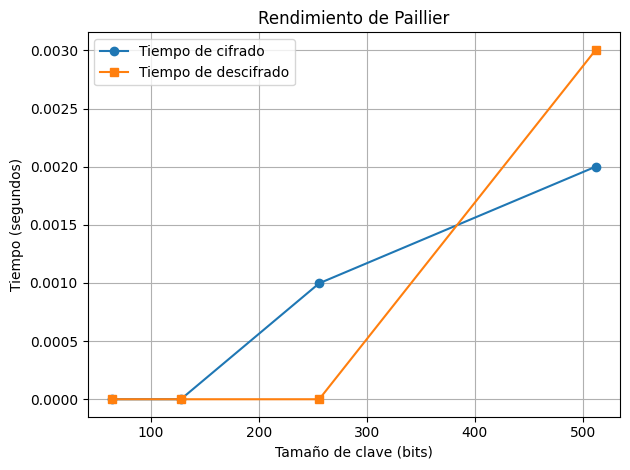

In [8]:
plt.plot(tamanos, tiempos_cifrado, marker='o', label='Tiempo de cifrado')
plt.plot(tamanos, tiempos_descifrado, marker='s', label='Tiempo de descifrado')
plt.xlabel('Tamaño de clave (bits)')
plt.ylabel('Tiempo (segundos)')
plt.title('Rendimiento de Paillier')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Conclusión

- Se observa que **al incrementar el tamaño de la clave (de 64 a 512 bits)**, el tiempo necesario para realizar tanto el **cifrado como el descifrado** también aumenta.
- El **cifrado presenta un crecimiento más estable y lineal**, mientras que el **descifrado se mantiene bajo hasta los 256 bits**, incrementándose considerablemente a partir de los 512 bits.
- Esto indica que **el algoritmo Paillier es eficiente con claves pequeñas**, pero **su rendimiento disminuye** con claves más grandes, especialmente durante el proceso de descifrado.
- Por tanto, existe una **relación directa entre seguridad y rendimiento**, lo cual debe considerarse al elegir el tamaño de clave para aplicaciones prácticas.